In [2]:
import jax.numpy as jnp
import jax
import equinox as eqx
import cryojax as cx
import cryojax.simulator as cxs
import src.ensemble_sim as sim
from cryojax.image.operators import FourierGaussian
from cryojax.rotations import SO3
import dataclasses
import os
import jax_dataloader as jdl
from typing import Any, Callable, final
from typing_extensions import override



import numpyro
import numpyro.distributions as dist

import logging
from functools import partial

import matplotlib.pyplot as plt

from cryojax.utils import get_filter_spec
from cryojax.utils._filtered_transformations import filter_vmap_with_spec
from cryojax.constants import get_tabulated_scattering_factor_parameters
from cryojax.io import read_atoms_from_pdb

from cryojax.data import RelionParticleStack, RelionParticleParameters,AbstractParticleStack, RelionParticleDataset, AbstractDataset
import cryo_reweighting.optimization as optimization


# Create list of pdb files for simulating images from

In [3]:
path_to_models="data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)


# Define a weight distribution on the pdb files
## Here, evaluating a gaussian mixture pdf on the indices of the pdbs

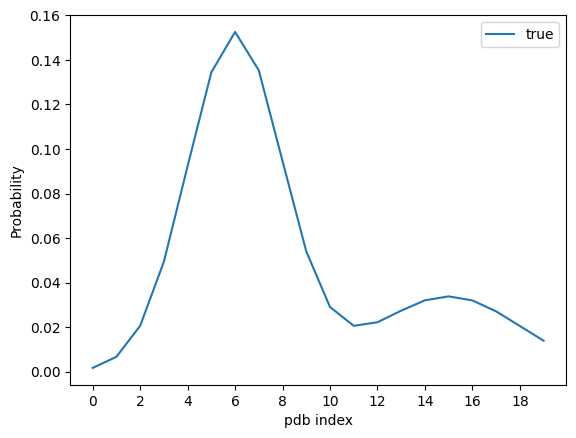

In [4]:
def GaussianMixture1D(weights, means, std_devs):
    weights = jnp.array(weights)
    means = jnp.array(means)
    std_devs = jnp.array(std_devs)
    mixing_dist = dist.Categorical(probs=weights/jnp.sum(weights))
    component_dist = dist.Normal(loc=means, scale=std_devs) 
    return dist.MixtureSameFamily(mixing_dist, component_dist) 

weights = [1., 1./3.]
means = [6., 15.]
std_devs = [2.0, 3.0]
mixture = GaussianMixture1D(weights, means, std_devs)
samples = mixture.sample(jax.random.PRNGKey(0), (10000,))
 
# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
weights = jnp.exp(mixture.log_prob(x))
weights /= dx*weights.sum() 
plt.plot(x, weights, label='true', color="C0")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()


# Define a config file for image simulation

In [5]:
# Bare bones config for this notebook
# Things that may need to be adjusted:
#   number of images, noise_snr
# Everything else, unlikely
config = {
"number_of_images": 10000,
"noise_var": 0.1,
"weights_models": weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}

# Note: defining new stuff here!!

In [6]:
def _get_particle_stack_filter_spec(particle_stack):
    return get_filter_spec(particle_stack, _pointer_to_vmapped_parameters)

def _pointer_to_vmapped_parameters(particle_stack):
    output = (
        particle_stack.parameters.transfer_theory.ctf.defocus_in_angstroms,
        particle_stack.parameters.transfer_theory.ctf.astigmatism_in_angstroms,
        particle_stack.parameters.transfer_theory.ctf.astigmatism_angle,
        particle_stack.parameters.transfer_theory.ctf.phase_shift,
        particle_stack.parameters.transfer_theory.envelope.b_factor,
        #particle_stack.parameters.transfer_theory.envelope.amplitude,
        particle_stack.parameters.pose.offset_x_in_angstroms,
        particle_stack.parameters.pose.offset_y_in_angstroms,
        particle_stack.parameters.pose.view_phi,
        particle_stack.parameters.pose.view_theta,
        particle_stack.parameters.pose.view_psi,
        particle_stack.image_stack,
    )
    return output



In [7]:
def compute_noisy_image(key, pipeline_singleton, pipeline_novmap, noise_args):
    pipeline = eqx.combine(pipeline_singleton, pipeline_novmap)
    image = pipeline.render()
    noised_image, noise_power = add_noise_(image, key, noise_args) 
    return noised_image, noise_power

def compute_image_stack_with_noise(key, config, imaging_pipeline_vmap, imaging_pipeline_novmap, noise_args):
    
    key, *subkeys = jax.random.split(key, config["number_of_images"] + 1)
    subkeys = jnp.array(subkeys)

    noised_images, noise_power_sq = jax.lax.map(
        lambda x: compute_noisy_image(key=x[0], pipeline_singleton=x[1], pipeline_novmap=imaging_pipeline_novmap, noise_args=noise_args),
        xs=(subkeys, imaging_pipeline_vmap),
        batch_size=100,
    )
    
    return noised_images, noise_power_sq

def add_noise_(image, key, noise_args):
    noise_grid, noise_radius_mask, noise_var = noise_args
    key, subkey = jax.random.split(key)
    radii_for_mask = noise_grid[None, :] ** 2 + noise_grid[:, None] ** 2
    mask = radii_for_mask < noise_radius_mask**2

    signal_power = jnp.sqrt(jnp.sum((image * mask) ** 2) / jnp.sum(mask))

    #noise_power = signal_power / jnp.sqrt(noise_snr)
    #image = image + jax.random.normal(subkey, shape=image.shape) * noise_power
    image = image + jax.random.normal(subkey, shape=image.shape) * noise_var**(0.5)
    return image, noise_var


In [8]:
# FROM cryoMD
from typing_extensions import override

from equinox import field
from jaxtyping import Float, Complex, Array, PRNGKeyArray

from cryojax.inference.distributions import AbstractDistribution
from cryojax.simulator import AbstractImagingPipeline

class WhiteGaussianNoise(AbstractDistribution, strict=True):
    r"""A gaussian noise model, where each fourier mode is independent.

    This computes the likelihood in Fourier space,
    so that the variance to be an arbitrary noise power spectrum.
    """

    imaging_pipeline: AbstractImagingPipeline
    noise_variance: Float | Array
    is_signal_normalized: bool = field(static=True)

    def __init__(
        self,
        imaging_pipeline: AbstractImagingPipeline,
        noise_variance: Float[Array, ""],  # noqa: F722
    ):
        """**Arguments:**

        - `imaging_pipeline`: The image formation model.
        - `noise_variance`: The variance of the noise in fourier space.
        """  # noqa: E501
        self.imaging_pipeline = imaging_pipeline
        self.noise_variance = noise_variance
        self.is_signal_normalized = False

    @override
    def compute_signal(
        self, *, get_real: bool = True
    ) -> Float[
        Array,
        "{self.imaging_pipeline.instrument_config.y_dim} "  # noqa: F722
        "{self.imaging_pipeline.instrument_config.x_dim}",  # noqa: F722
    ]:
        """Render the image formation model."""

        simulated_image = self.imaging_pipeline.render(get_real=True)
        return simulated_image

    def compute_noise(
        self, rng_key: PRNGKeyArray, *, get_real: bool = True
    ) -> Float[
        Array,
        "{self.imaging_pipeline.instrument_config.y_dim} "  # noqa: F722
        "{self.imaging_pipeline.instrument_config.x_dim}",  # noqa: F722
    ]:
        pipeline = self.imaging_pipeline
        # Compute the zero mean variance and scale up to be independent of the number of
        # pixels
        noise = jax.random.normal(rng_key, shape=pipeline.instrument_config.shape) * jnp.sqrt(
            self.noise_variance
        )

        return noise

    @override
    def sample(
        self, rng_key: PRNGKeyArray, *, get_real: bool = True
    ) -> Float[
        Array,
        "{self.imaging_pipeline.instrument_config.y_dim} "  # noqa: F722
        "{self.imaging_pipeline.instrument_config.x_dim}",  # noqa: F722
    ]:
        """Sample from the gaussian noise model."""

        noisy_image = self.compute_signal(get_real=get_real) + self.compute_noise(
            rng_key, get_real=get_real
        )
        return noisy_image

    @override
    def log_likelihood(
        self,
        observed: Complex[
            Array,
            "{self.imaging_pipeline.instrument_config.y_dim} "  # noqa: F722
            "{self.imaging_pipeline.instrument_config.x_dim//2+1}",  # noqa: F722
        ],
    ) -> Float:
        """Evaluate the log-likelihood of the gaussian noise model.

        **Arguments:**

        - `observed` : The observed data in fourier space.
        """
        # Create simulated data
        simulated = self.compute_signal(get_real=True)

        # Compute residuals
        log_likelihood = -jnp.sum((simulated - observed ) ** 2 / (2 * self.noise_variance)
        )

        return log_likelihood

In [9]:
# Create static image formation stuff
imaging_args = sim.build_image_formation_stuff(config)

# Create noise stuff
noise_grid = jnp.linspace(
                 -0.5 * (config["box_size"] - 1),
                 0.5 * (config["box_size"] - 1),
                 config["box_size"],
             )
noise_radius = 0.5*config["box_size"] - 1 # For now, using a disc that is radius of the image for SNR calculations
noise_args = noise_grid, noise_radius, config["noise_var"] 

def get_pipeline_info(imaging_pipeline):
    """Custom function for returning various stats from an imaging pipeline"""
    info = {}
    info["conformation"] = imaging_pipeline.scattering_theory.structural_ensemble.conformation.value  
    #info["..."] = ...

    return info

# NOTE: here there is no argument at all for weights, since the weight dist is defined in config
def sample_images(key, config, imaging_args, noise_args):

    # Generate RNG keys for individual images
    key, *subkeys = jax.random.split(key, config["number_of_images"] + 1)
    subkeys = jnp.array(subkeys)

    print(subkeys.shape)
    # Pipeline
    # NOTE: these extra `eqx.combine' lines are just here because we are paying the piper for having very specific vmaps 
    imaging_pipeline_vmap, imaging_pipeline_novmap = sim.make_imaging_pipeline(subkeys, imaging_args)
    imaging_pipeline = eqx.combine(imaging_pipeline_vmap, imaging_pipeline_novmap)

    parameters = RelionParticleParameters(instrument_config=imaging_args["instrument_config"], 
                                          transfer_theory=imaging_pipeline.scattering_theory.transfer_theory,
                                          pose=imaging_pipeline.scattering_theory.structural_ensemble.pose) 
    
    extra_info = get_pipeline_info(imaging_pipeline)

    noised_images, noise_power_sq = compute_image_stack_with_noise(key, config, imaging_pipeline_vmap, imaging_pipeline_novmap, noise_args)

    imaging_stack = RelionParticleStack(parameters, noised_images)

    return imaging_stack, noise_power_sq, extra_info


# Simulate a dataset!

In [10]:
key = jax.random.PRNGKey(config["rng_seed"])
imaging_stack, noise_power_sq, extra_info = sample_images(key,config, imaging_args, noise_args)
noised_images = imaging_stack.image_stack

#print(noise_power_sq)
#plt.hist(noise_power_sq)
#print(jnp.mean(jnp.mean(noised_images**2,))

(10000, 2)


In [11]:
filter_spec = _get_particle_stack_filter_spec(imaging_stack)
imaging_stack_vmap, imaging_stack_novmap = eqx.partition(
             imaging_stack, filter_spec)

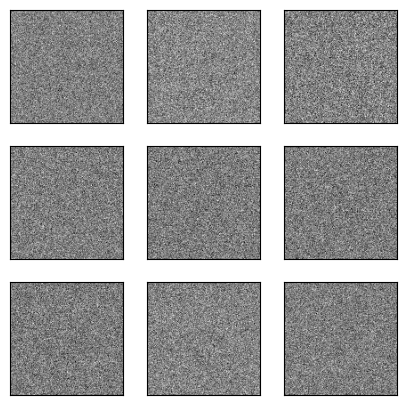

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(noised_images[idx,:], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)


## Checking the conformation idx of each individual image
This is a quick check that the sampled conformations actually match the distribution we specified, and a simple use of the per-image conformation info we are tracking

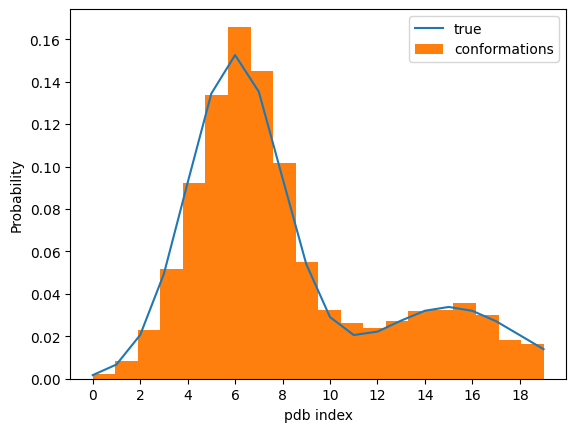

In [13]:
# this is reading out the true conformation index of each image
conformations = extra_info["conformation"]

# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
true_weights = jnp.exp(mixture.log_prob(x))
true_weights /= true_weights.sum()
plt.plot(x, true_weights, label='true', color="C0")
plt.hist(conformations, bins=20, range=(0, 19), density=True, label='conformations', color="C1")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()


# Trying to compute likelihoods


In [14]:
@eqx.filter_jit
def compute_log_likelihood_single_conformation(
    potential, observed_imaging_stack_vmap, observed_imaging_stack_novmap):

    observed_imaging_stack = eqx.combine(observed_imaging_stack_vmap, observed_imaging_stack_novmap)
    parameters = observed_imaging_stack.parameters

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, parameters.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble=structural_ensemble,
        potential_integrator=cxs.FourierSliceExtraction(interpolation_order=1),
        #potential_integrator = cxs.GaussianMixtureProjection(),
        transfer_theory=parameters.transfer_theory,
    )

    instrument_config = parameters.instrument_config

    simulated_imaging_pipeline = cxs.ContrastImagingPipeline(
        instrument_config, scattering_theory
    )

    simulated_distribution = WhiteGaussianNoise(simulated_imaging_pipeline, noise_variance=jnp.mean(noise_power_sq))
    return simulated_distribution.log_likelihood(observed_imaging_stack.image_stack) 

@eqx.filter_jit
@partial(eqx.filter_vmap, in_axes=(0, None, None), out_axes=0)
def compute_log_likelihood_all_images_single_conformation(atom_positions,imaging_stack_vmap, args):

    atom_identities, b_factors, parameter_table, imaging_stack_novmap = (
        args
    )

    parameters = imaging_stack_novmap.parameters
    instrument_config = parameters.instrument_config

    atom_potential = cxs.PengAtomicPotential(
        atom_positions,
        atom_identities,
        b_factors,
        scattering_factor_parameter_table=parameter_table,
    )

    real_voxel_grid = atom_potential.as_real_voxel_grid(
        (instrument_config.shape[0],) * 3,
        instrument_config.pixel_size,
        batch_size_for_z_planes=10,
    )

    voxel_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
        real_voxel_grid,
        instrument_config.pixel_size
    )

    likelihoods = jax.lax.map(
        lambda x: compute_log_likelihood_single_conformation(
            potential=voxel_potential, observed_imaging_stack_vmap=x, observed_imaging_stack_novmap=imaging_stack_novmap
        ),
        xs=imaging_stack_vmap,
        batch_size=1000,
    )

    return likelihoods


In [15]:
pdb_fnames = config["models_fnames"]
path_to_models = config["path_to_models"]
filename = path_to_models + "/" + pdb_fnames[0]
_, atom_identities, b_factors = read_atoms_from_pdb(
    filename, get_b_factors=True)
parameter_table = get_tabulated_scattering_factor_parameters(atom_identities)

args = (atom_identities, b_factors, parameter_table, imaging_stack_novmap)

atom_positions_all = []
for i in range(len(pdb_fnames)):
    filename = path_to_models + "/" + pdb_fnames[i]
    atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, get_b_factors=True
    )
    atom_positions_all.append(atom_positions)
atom_positions_all = jnp.stack(atom_positions_all)
print(atom_positions_all.shape)

(20, 9758, 3)


In [16]:
log_likelihood = compute_log_likelihood_all_images_single_conformation(atom_positions_all, imaging_stack_vmap, args).T



<BarContainer object of 20 artists>

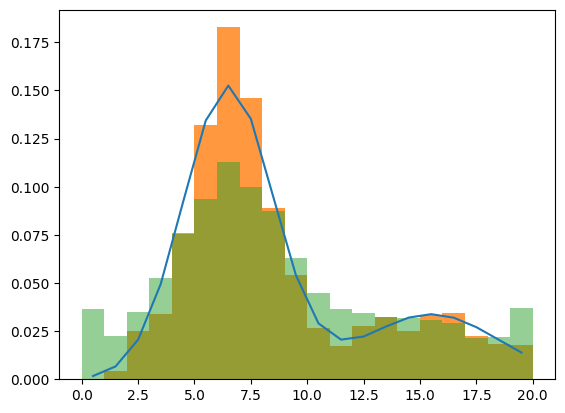

In [17]:
nodes = jnp.arange(0, 20, 1) + 0.5
x = jnp.argmax(log_likelihood, axis = 1)
hard_weights, _ = jnp.histogram(x, bins =jnp.arange(0, 21, 1))
hard_weights /= jnp.sum(hard_weights)
log_likelihood_aux = log_likelihood - jnp.max(log_likelihood, 1)[:, jnp.newaxis]
    
# NOTE: we cannot exponentiate this if previous step hasn't happened 
weights = (1/log_likelihood.shape[1])*jnp.ones(log_likelihood.shape[1])
likelihood = jnp.exp(log_likelihood_aux)
model = jnp.sum(likelihood*weights, axis=1)
grad = jnp.mean(likelihood/model[:, jnp.newaxis], axis=0) 
weights = weights*grad
softmax_weights = optimization.multiplicative_gradient(log_likelihood, max_iterations=1)

plt.plot(nodes, true_weights, label='true', color="C0")
ensemble_weights = optimization.multiplicative_gradient(log_likelihood, max_iterations=100)
plt.bar(nodes, ensemble_weights, 
        width=1, label='EM Weights', color="C1", alpha=0.8)
plt.bar(nodes, hard_weights, 
        width=1, label='EM Weights', color="C2", alpha=0.5)


